# 🩺 Breast Cancer Prediction 
**Dataset:** `data.csv` (Wisconsin Diagnostic — 569 rows, 30 numeric features + target).

**Goal:** Build a **robust, well‑validated** classifier with nested cross‑validation, learning curves, and model‑agnostic interpretability.

## Step‑by‑Step Guide
1) Setup & imports
2) Load & clean (drop `id`, handle `Unnamed: 32`, encode `diagnosis`)
3) EDA (class balance, quick stats) — optional visuals
4) Nested cross‑validation (inner tuning, outer testing)
5) Learning curve (does more data help?)
6) Final fit + evaluation on a holdout split
7) Permutation importance (top features)


### 1) Setup & imports

In [8]:
# !pip install pandas numpy scikit-learn matplotlib seaborn
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report, RocCurveDisplay
from sklearn.inspection import permutation_importance

### 2) Load & clean

In [9]:
DATA_PATH = 'data.csv'
df = pd.read_csv(DATA_PATH)
# Drop ID-like and empty columns
for col in ['id','Unnamed: 32']:
    if col in df.columns:
        df = df.drop(columns=[col])
# Encode diagnosis: M=1 (malignant), B=0 (benign)
df['diagnosis'] = df['diagnosis'].map({'M':1,'B':0})
display(df.head())
display(df.isnull().sum())

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

### 3) EDA (quick)

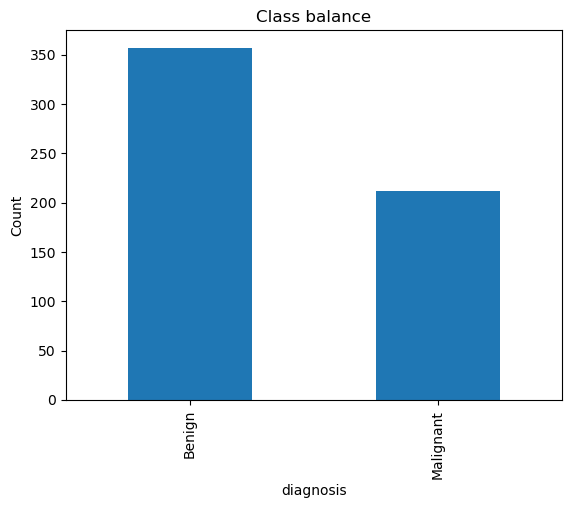

,count,mean,std,min,25%,50%,75%,max
diagnosis,569.0,0.372583,0.483918,0.00000,0.00000,0.00000,1.0000,1.0000
radius_mean,569.0,14.127292,3.524049,6.98100,11.70000,13.37000,15.7800,28.1100
texture_mean,569.0,19.289649,4.301036,9.71000,16.17000,18.84000,21.8000,39.2800
perimeter_mean,569.0,91.969033,24.298981,43.79000,75.17000,86.24000,104.1000,188.5000
area_mean,569.0,654.889104,351.914129,143.50000,420.30000,551.10000,782.7000,2501.0000
smoothness_mean,569.0,0.096360,0.014064,0.05263,0.08637,0.09587,0.1053,0.1634
compactness_mean,569.0,0.104341,0.052813,0.01938,0.06492,0.09263,0.1304,0.3454
concavity_mean,569.0,0.088799,0.079720,0.00000,0.02956,0.06154,0.1307,0.4268
concave points_mean,569.0,0.048919,0.038803,0.00000,0.02031,0.03350,0.0740,0.2012
symmetry_mean,569.0,0.181162,0.027414,0.10600,0.16190,0.17920,0.1957,0.3040


In [10]:
ax = df['diagnosis'].value_counts().sort_index().rename({0:'Benign',1:'Malignant'}).plot(kind='bar', title='Class balance')
plt.ylabel('Count'); plt.show()
display(df.describe().T.head(10))

### 4) Nested cross‑validation
We use **Logistic Regression (L2)** as a strong, interpretable baseline.
- **Inner loop:** hyperparameter tuning (C)
- **Outer loop:** unbiased AUC estimation

In [11]:
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']
inner = KFold(n_splits=5, shuffle=True, random_state=42)
outer = KFold(n_splits=5, shuffle=True, random_state=42)
pipe = Pipeline([('sc', StandardScaler()), ('lr', LogisticRegression(max_iter=1000))])
params = {'lr__C':[0.1, 1, 3, 10]}
gs = GridSearchCV(pipe, params, cv=inner, scoring='roc_auc')
scores = cross_val_score(gs, X, y, cv=outer, scoring='roc_auc')
print('Nested AUC mean±std:', scores.mean(), scores.std())

Nested AUC mean±std: 0.9943809909849207 0.005669055274376576


### 5) Learning curve

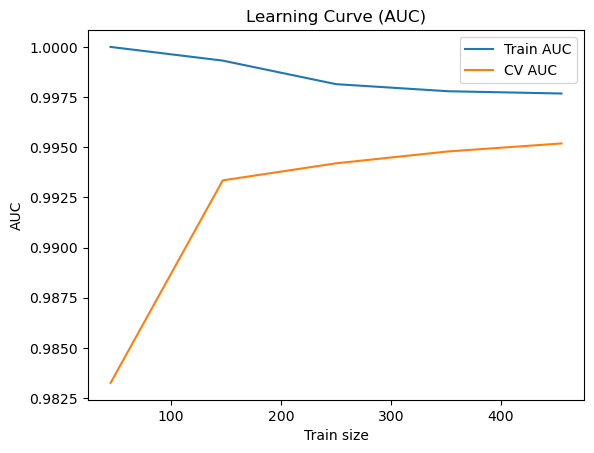

In [12]:
train_sizes, train_scores, test_scores = learning_curve(pipe, X, y, cv=5, train_sizes=np.linspace(0.1,1.0,5), scoring='roc_auc')
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train AUC')
plt.plot(train_sizes, test_scores.mean(axis=1), label='CV AUC')
plt.legend(); plt.title('Learning Curve (AUC)'); plt.xlabel('Train size'); plt.ylabel('AUC'); plt.show()

### 6) Final fit + evaluation on holdout split

Test AUC: 0.9920634920634921
Test Accuracy: 0.9736842105263158
Test F1: 0.963855421686747
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



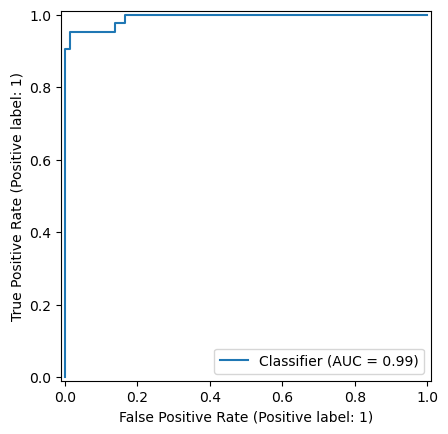

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
best = GridSearchCV(pipe, params, cv=5, scoring='roc_auc').fit(X_train, y_train).best_estimator_
proba = best.predict_proba(X_test)[:,1]
pred = (proba >= 0.5).astype(int)
print('Test AUC:', roc_auc_score(y_test, proba))
print('Test Accuracy:', accuracy_score(y_test, pred))
print('Test F1:', f1_score(y_test, pred))
print(classification_report(y_test, pred))
RocCurveDisplay.from_predictions(y_test, proba); plt.show()

### 7) Permutation importance (model‑agnostic)

In [14]:
best.fit(X_train, y_train)
res = permutation_importance(best, X_test, y_test, scoring='roc_auc', n_repeats=10, random_state=42)
imp = pd.Series(res.importances_mean, index=X.columns).sort_values(ascending=False).head(15)
display(imp)

texture_worst             0.020370
symmetry_worst            0.017989
concavity_worst           0.017626
concave points_mean       0.008466
concavity_mean            0.008201
concave points_worst      0.004134
radius_se                 0.003836
radius_worst              0.003472
area_worst                0.003075
texture_se                0.002612
concave points_se         0.002183
perimeter_worst           0.001786
area_se                   0.001653
fractal_dimension_mean    0.001025
smoothness_mean           0.001025
dtype: float64